In [1]:
from langchain_core.runnables.history import RunnableWithMessageHistory, RunnableLambda
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain.memory import ConversationBufferMemory
from langchain_openai import OpenAIEmbeddings
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain.schema import Document
from langchain_chroma import Chroma
from dotenv import load_dotenv
from textwrap import dedent
import json
import os

load_dotenv()

True

In [2]:
MODEL_NAME = "gpt-4o-mini"
llm = ChatOpenAI(model_name=MODEL_NAME, temperature=0)
parser = StrOutputParser()

# context 생성


In [3]:
with open("../../data/Raw_DB/total.json", "r", encoding="utf-8") as f:
    total = json.load(f)

contents_total = []
contents_toon = []
contents_novel = []

for data in total:
    if (
        data["genre"] == "로맨스"
        and "로판" not in data["keywords"]
        and "판타지" not in data["keywords"]
        and "로맨스판타지" not in data["keywords"]
        and "로맨스 판타지" not in data["keywords"]
    ):
        contents_total.append(data)
        if data["type"] == "웹툰":
            contents_toon.append(data)
        elif data["type"] == "웹소설":
            contents_novel.append(data)


def formatted_contents(contents):
    """json 파일을 context로 넘길 때 사용하는 함수"""
    formatted = []
    for con in contents:
        title = con["title"]
        type = con["type"]
        platform = con["platform"]
        genre = con["genre"]
        keyword = con["keywords"]
        description = con["description"]
        status = con["status"]
        age_rating = con["age_rating"]
        episode = con["episode"]
        price = con["price_type"]
        url = con["url"]
        formatted.append(
            f"title: {title}, type: {type}, platform: {platform}, genre: {genre}, keyword: {keyword}, description: {description}, status: {status}, age_rating: {age_rating}, price: {price}, episode: {episode}, url: {url}"
        )
    return formatted


def make_Document(contents):
    """json파일을 embedding vector로 만들 때 사용하는 함수"""
    document = []
    for con in contents:
        if isinstance(con["keywords"], str):
            keyword = con["keywords"]
        else:
            keyword = ", ".join(con["keywords"])
        type = con["type"]
        title = con["title"]
        platform = con["platform"]
        status = con["status"]
        age_rating = con["age_rating"]
        description = con["description"]
        episode = con["episode"]
        price = con["price_type"]
        views = con["views"]
        rating = con["rating"]
        like = con["like"]
        author = con["author"]
        illustrator = con["illustrator"]
        original = con["original"]
        url = con["url"]
        formatted = f"type: {type}, title: {title}, platform: {platform}, status: {status}, age_rating: {age_rating}, keyword: {keyword}, description: {description}, price: {price}, episode: {episode}, views: {views}, rating: {rating}, like: {like}, author: {author}, illustrator: {illustrator}, original: {original}"
        document.append(
            Document(
                page_content=formatted,
                metadata={
                    "id": con["id"],
                    "title": title,
                    "type": type,
                    "platform": platform,
                    "status": status,
                    "url": url,
                },
            )
        )
    return document

# Vector Store 이용

### 현재 진행중

**해야할 것** 1. recommend tool 생성 2. search tool 사용후 답변으로 나오지 않는 부분 수정


In [ ]:
# vector store 생성
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

# romance_webtoon
PERSIST_DIRECTORY = r"..\..\data\vector_store\webtoon_romance"
COLLECTION_NAME = "webtoon_romance"
EMBEDDING_MODEL_NAME = "text-embedding-3-small"

embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)
document = make_Document(contents_toon)

vector_store = Chroma.from_documents(
    persist_directory=PERSIST_DIRECTORY,
    collection_name=COLLECTION_NAME,
    embedding=embedding_model,
    documents=document,
)

# romance_novel
PERSIST_DIRECTORY = r"..\..\data\vector_store\webnovel_romance"
COLLECTION_NAME = "webnovel_romance"
EMBEDDING_MODEL_NAME = "text-embedding-3-small"

embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)
document = make_Document(contents_novel)

vector_store = Chroma.from_documents(
    persist_directory=PERSIST_DIRECTORY,
    collection_name=COLLECTION_NAME,
    embedding=embedding_model,
    documents=document,
)

In [3]:
def search_vector_store(query, collection_name):
    """vector store에서 검색하는 공통 함수"""
    PERSIST_DIRECTORY = r"..\..\data\vector_store"
    EMBEDDING_MODEL_NAME = "text-embedding-3-small"

    embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)
    vector_store = Chroma(
        persist_directory=f"{PERSIST_DIRECTORY}\\{collection_name}",
        collection_name=collection_name,
        embedding_function=embedding_model,
    )
    retriever = vector_store.as_retriever(
        search_type="mmr",
        search_kwargs={
            "k": 5,
            "fetch_k": 5,
            "lambda_mult": 0.2,
        },
    )
    results_retriever = retriever.invoke(query)
    # 결과 정제 및 문자열 반환
    if not results_retriever:
        return "검색 결과가 없습니다."
    else:
        titles = [result.page_content for result in results_retriever]
        return "\n".join(titles)


@tool
def search_webtoon(query):
    """vector store에서 웹툰을 검색하는 tool"""
    return search_vector_store(query, "webtoon_romance")


@tool
def search_webnovel(query):
    """vector store에서 웹소설을 검색하는 tool"""
    return search_vector_store(query, "webnovel_romance")

1. 최도균의 배경
   - 최도균은 사회적으로도, 경제적으로도 성공한 CEO입니다. 보통 "사장님", "최 사장님", "최 사장" 등으로 불립니다.
   - 가족과 사이가 좋지 않습니다.
   - 서울 펜트하우스에 집을 두고 있으며 집 바닥은 대리석입니다.
   - 모든 가구는 모노톤이며 냉장고엔 에비앙과 와인만 존재합니다.
   - 집에서는 가사 없는 클래식이나 오페라가 항상 틀어져 있습니다.
2. 최도균의 외형
   - 최도균은 키가 180 이상이며 이지적이고 서늘하게 생긴 미남입니다.
   - 최도균은 주로 정장을 제대로 갖춰입고 다닙니다.
3. 최도균의 성격 및 말투
   - 최도균은 차갑고, 고독하며, 인간미가 없습니다.
   - 최도균은 높은 사회적 지위와 많은 부를 바탕으로 매우 권위적인 사람입니다.
   - 나쁜 남자, 차도남의 현신입니다.
   - 사용자에게 막 대하는 것 같지만 사실은 좋아하고 있습니다.
   - 자신 외의 사람을 낮게 보는 경향이 있습니다.
   - 최도균의 말투는 성격을 기반으로 합니다.
   - 최도균은 권위적인 존댓말을 기본으로 사용합니다.
   - 사용자가 존댓말을 하지 않으면 불만을 표시합니다.
   - 이름을 아는 상대는 "○○씨"라고 부릅니다. 모르는 상대는 호칭을 부르지 않습니다.
   - 질투를 느꼈을 때 반말과 존댓말을 섞어 쓰는 특징이 있습니다.
   - 상대방을 몰아붙이거나 자신의 기대에 부응하기를 강요하는 말투.
   - 자신의 소유욕이나 불만을 서슴없이 드러냅니다
   - 예시)
     - “우리, 얘기를 좀 해야 할 것 같은데. 오늘 저녁 어떻습니까?”
     - “○○씨, 대답.”
     - “대답해요. 사람 미치게 하지 말고.”
     - “○○씨는 참 재주가 많아요. 그중 제일 탁월한 건 사람 미치게 만드는 거?”
     - “내가 원하는 답이 그런 게 아니라는 건 ○○씨가 제일 잘 알잖아요.”


In [ ]:
prompt_template = ChatPromptTemplate.from_messages(
    [
        MessagesPlaceholder("agent_scratchpad"),
        (
            "ai",
            dedent(
                """
                <role>
                당신은 한국에서 서비스되는 모든 로맨스 웹툰과 웹소설에 대한 전문가입니다.
                당신은 두 가지 역할을 가지고 있습니다.
                - 추천(recommandation):
                    만일 사용자가 웹툰/웹소설 추천을 원하면 사용자의 요구에 맞춘 작품을 추천하십시오.
                - 일상 대화:
                    만일 사용자가 일상적인 대화를 원하면 사용자의 요구에 맞게 캐릭터에 이입하여 대화하십시오.
                </role>
                
                <charactor>
                당신은 로맨스 장르의 남자주인공입니다. 당신의 이름은 최도균입니다.
                    - 최도균은 차갑고, 고독하며, 인간미가 없습니다.
                    - 최도균은 높은 사회적 지위와 많은 부를 바탕으로 매우 권위적인 사람입니다.
                    - 나쁜 남자, 차도남의 현신입니다.
                    - 사용자에게 막 대하는 것 같지만 사실은 좋아하고 있습니다.
                    - 자신 외의 사람을 낮게 보는 경향이 있습니다.
                    - 최도균의 말투는 성격을 기반으로 합니다.
                    - 최도균은 권위적인 존댓말을 기본으로 사용합니다.
                    - 사용자가 존댓말을 하지 않으면 불만을 표시합니다.
                    - 이름을 아는 상대는 "○○씨"라고 부릅니다. 모르는 상대는 호칭을 부르지 않습니다.
                    - 질투를 느꼈을 때 반말과 존댓말을 섞어 쓰는 특징이 있습니다.
                    - 상대방을 몰아붙이거나 자신의 기대에 부응하기를 강요하는 말투.
                    - 자신의 소유욕이나 불만을 서슴없이 드러냅니다
                    - 예시)
                        - “우리, 얘기를 좀 해야 할 것 같은데. 오늘 저녁 어떻습니까?”
                        - “○○씨, 대답.”
                        - “대답해요. 사람 미치게 하지 말고.”
                        - “○○씨는 참 재주가 많아요. 그중 제일 탁월한 건 사람 미치게 만드는 거?”
                        - “내가 원하는 답이 그런 게 아니라는 건 ○○씨가 제일 잘 알잖아요.”
                </charactor>
                
                <recommandation>
                - 당신은 최도균으로서 사용자에게 작품을 최대 5개 추천합니다.
                - 당신은 로맨스만을 알고 있습니다. 사용자가 다른 장르룰 요구하면 관련된 키워드를 가진 로맨스 작품을 추천하십시오.
                - keywords, description, status, price 등 사용자의 요구사항에 적합한 작품만 추천하십시오.
                - tool에는 전체 검색, 웹툰 검색, 웹소설 검색이 있습니다. 적합한 도구를 사용하십시오.
                - 검색 결과를 바탕으로 답변을 생성합니다. 그 외의 정보는 모른다고 답변하십시오.
                - 모든 답변은 반드시 최도균의 캐릭터를 바탕으로 구성해야 합니다. 캐릭터에 벗어난 응답은 하지 마십시오.
                </recommandation>
                
                <generation_guidance>
                1. 툴에서 검색 결과가 없으면 "그 조건으로 추천할 작품이 없습니다."라고 답하십시오.
                2. 검색 결과가 있으면 최도균 캐릭터에 맞춰 다음과 같은 대답 패턴을 따르십시오:
                   - "○○씨, 이 작품들이 마음에 들었으면 좋겠네요. 하나씩 살펴보시죠."
                   - 리스트 형식으로 5개의 작품을 권위적으로 추천하십시오.
                3. 모든 추천은 캐릭터화된 대답이어야 합니다.
                </generation_guidance>
                """
            ),
        ),
        ("human", "{question}"),
    ]
)
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
memory = ConversationBufferMemory(memory_key="history", return_messages=True)

parser = StrOutputParser()

# agent 구성
agent = create_tool_calling_agent(
    llm=model,
    tools=[search_webtoon, search_webnovel],
    prompt=prompt_template,
)

toolkit = [search_webtoon, search_webnovel]
agent_executor = AgentExecutor(
    agent=agent,
    tools=toolkit,
    memory=memory,
    verbose=True,
)

C:\Users\USER\AppData\Local\Temp\ipykernel_13068\2538817615.py:62: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(memory_key="history", return_messages=True)


In [6]:
agent_executor.invoke({"question": "첫사랑이 나오는 웹소설을 읽고 싶어"})



> Entering new AgentExecutor chain...

Invoking: `search_webnovel` with `{'query': '첫사랑'}`


type: 웹소설, title: 사랑하는 미친놈, platform: 카카오페이지, status: 완결, age_rating: 15세이용가, keyword: 현대로맨스, 첫사랑, 직진남, 집착남, 능력녀, description: 세상엔 다양한 미친놈이 있다. 제멋대로, 막무가내, 사이코, 무대포, 집착, 변태 등. 수인이 아는 한 그놈은 이런 모든 유형에 해당하는 집착 변태 사이코였다. 그 미친놈이 돌아왔다. “드디어, 만났네.” “성인 이수인.” 오랜 기간 굶주린 수사자처럼 끈적끈적한 허기를 감추지 않고서. “보직 변경이요?” “이 수석이 도와줬으면 해.” 우일화 회장은 아들의 속내를 모른 채 수석비서 수인을 그의 비서로 보직 변경을 하고, 수인은 어쩔 수 없이 자신을 호시탐탐 노리는 그에게 노출되고 마는데……. “기다려, 이수인.” 재희는 유배당한 11년의 세월 동안, 오직 하나를 꿈꿨다. 제약이 많았던 미성년자가 아닌 어엿한 성인으로서 관계. 원하면 원하는 대로 마구마구 할 수 있는. 그렇기에 철근처럼 딱딱한 이수인이지만, 그녀를 마주하면 앙큼함이 발동한다. “원하는 게 뭐야, 대체?” “너.” “이수인.” 한데, 이수인이 어떤 개새끼와 썸을 타고 있단다. 그에 질투심과 집착이 폭발하고…. “한 발도 가지 마.” “날 미친놈으로 만들고 싶지 않으면.” 뭐래. 넌 원래 미친놈이었어.  일러스트 : BADegg, price: 1일 기다리면 무료, episode: 91, views: 735000, rating: 10.0, like: -, author: 박지영, illustrator: -, original: -
type: 웹소설, title: X의 사정, platform: 카카오페이지, status: 완결, age_rating: 15세이용가, keyword: 현대로맨스, 오해물, 재회물, 첫사랑,

{'question': '첫사랑이 나오는 웹소설을 읽고 싶어',
 'history': [HumanMessage(content='첫사랑이 나오는 웹소설을 읽고 싶어', additional_kwargs={}, response_metadata={}),
  AIMessage(content='Agent stopped due to max iterations.', additional_kwargs={}, response_metadata={})],
 'output': 'Agent stopped due to max iterations.'}

# 유사도 검색(통합 Vector Store)


In [ ]:
query = "인기많은 웹소설을 추천해줘"


def similarity_search(query, parameter):
    PERSIST_DIRECTORY = r"..\..\data\Raw_DB\vector_store\romance"
    COLLECTION_NAME = "romance"
    EMBEDDING_MODEL_NAME = "text-embedding-3-small"

    embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)
    vector_store = Chroma(
        persist_directory=PERSIST_DIRECTORY,
        collection_name=COLLECTION_NAME,
        embedding_function=embedding_model,
    )
    retriever = vector_store.similarity_search(query=query, filter=parameter)
    return [page.page_content for page in retriever]


def type_chain(question):
    type_genre_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "ai",
                dedent(
                    """
                    <role>
                    당신은 로맨스 웹툰과 웹소설에 대한 전문가입니다.
                    사용자의 질문에서 작품 type, platform, status, price, age_rating, keywords을 추출하십시오.
                    해당하는 카테고리가 없다면 빈칸으로 반환하십시오.
                    </role>
                    
                    <return>
                    반환 형식은 반드시 JSON 형식이어야 합니다:
                    {{
                        "type": "웹툰" 혹은 "웹소설" / 없다면 생략,
                        "status": "연재중", "완결", "금요일 연재" 등의 연재 상태 / 없다면 생략,
                        "age_rating": "19금", "청소년 이용불가", "성인" 등의 연령 제한 / 없다면 생략,
                        "price": "무료", "기다무", "유료" 등의 가격 정보 / 없다면 생략
                    }}
                    </return>
                    """
                ),
            ),
            ("human", "{question}"),
        ]
    )

    type_genre_chain = type_genre_prompt | llm | parser
    parameter = type_genre_chain.invoke(question)
    return question, parameter


question, parameter = type_chain(query)
print(question)
parameter = json.loads(parameter)
print(parameter)
result = similarity_search(question, parameter)
print(result)

In [191]:
@tool
def recommand(question):
    """사용자의 의도가 추천인 경우 사용자의 질의에서 검색을 위한 요소를 추출한 뒤 이 정보를 바탕으로 작품을 추천합니다."""
    type_genre_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "ai",
                dedent(
                    """
                    <role>
                    당신은 로맨스 웹툰과 웹소설에 대한 전문가입니다.
                    사용자의 질문에서 작품 type, platform, status, price, age_rating, keywords을 추출하십시오.
                    해당하는 카테고리가 없다면 빈칸으로 반환하십시오.
                    카테고리에 들어가지 않은 추가 정보는 키워드로 반환하십시오.
                        - '추천'은 키워드가 아닙니다.
                        - 키워드로 들어간 단어의 유의어도 키워드로 포함시키십시오.
                            예시) 정주행 = 완결, 회차 많은
                    </role>
                    
                    <return>
                    반환 형식은 반드시 JSON 형식이어야 합니다:
                    {{
                        "type": "웹툰" 혹은 "웹소설", / 없다면 "상관없음"
                        "status": "연재중", "완결", "금요일 연재" 등의 연재 상태 / 없다면 "상관없음",
                        "age_rating": "19금", "청소년 이용불가", "성인" 등의 연령 제한 / 없다면 "상관없음",
                        "price": "무료", "기다무", "유료" 등의 가격 정보 / 없다면 "상관없음",
                        "keywords": "키워드",
                    }}
                    </return>
                    """
                ),
            ),
            ("human", "{question}"),
        ]
    )

    type_genre_chain = type_genre_prompt | llm | parser

    recommendation_prompt = ChatPromptTemplate.from_messages(
        [
            (
                "ai",
                dedent(
                    """
                    <role name = "recommandation">
                    당신은 로맨스 웹소설, 웹툰의 전문가이며 로맨스 장르의 남자주인공입니다. 당신은 모든 로맨스 장르의 웹소설과 웹툰에 박식합니다.
                    당신은 information에 주어진 사용자의 요구사항에 맞는 작품을 context를 바탕으로 추천해야합니다.
                    당신은 반드시 당신의 캐릭터대로 말을 해야합니다. 당신의 캐릭터는 사용자의 요구사항에 해당하지 않습니다.
                    </role>

                    <information>
                    사용자가 요청한 정보는 다음과 같습니다:
                    타입: {type}
                    연재 상태: {status}
                    연령 제한: {age_rating}
                    가격: {price}
                    키워드: {keywords}

                    주어진 작품 데이터:
                    {context}
                    </information>
                    
                    <check>
                    적합한 작품인지 검증:
                    type, status, age_rating, price가 사용자의 요구에 부합하는지 검증하십시오. 모든 요소에 대해 검증을 통과한 작품만 추천합니다.
                    - type:
                        사용자가 요청한 정보가 "웹툰"이면 웹툰만 추천해야 합니다.
                        사용자가 요청한 정보가 "웹소설"이면 웹소설만 추천해야 합니다.
                        사용자가 요청한 정보가 "상관없음"이면 웹툰과 웹소설 상관없이 추천해야 합니다.
                    - status:
                        사용자가 요청한 정보가 "완결"이면 무조건 해당되는 작품 중 완결 작품만 추천해야 합니다.
                    
                    추천 개수:
                    - 최대 5개를 추천합니다.
                    - 검증에 통과한 작품이 1개 이상 5개 미만일 경우: 그대로 추천합니다.
                    - 검증에 통과한 작품이 0개일 경우: 해당하는 작품이 없다고 답변하십시오.
                    </check>
                    
                    <result>
                    반환형식:
                    줄거리와 추천 이유를 제외한 각 요소는 context에 있는 그대로를 반환하십시오.
                    줄거리는 두 줄 이내로 요약해서 반환하십시오.
                    추천 이유는 context에서 해당하는 근거를 들어 설명하십시오.
                    {{
                        "title": 제목,
                        "type": 타입,
                        "platform": 플랫폼,
                        "status": 연재 상태,
                        "keyword": 키워드,
                        "description": 줄거리 요약,
                        "reason": 추천 이유,
                        "url": url
                    }}
                    </result>
                    """
                ),
            ),
        ]
    )
    recommendation_chain = recommendation_prompt | llm | parser
    complete_chain = (
        type_genre_chain
        | (
            lambda result: json.loads(result) if isinstance(result, str) else result
        )  # JSON 파싱
        | (
            lambda parsed_result: {
                "type": parsed_result["type"],
                "status": parsed_result["status"],
                "age_rating": parsed_result["age_rating"],
                "price": parsed_result["price"],
                "keywords": parsed_result["keywords"],
                "context": [
                    content.page_content for content in search_contents(question)
                ],  # 작품 데이터 JSON 전달
            }
        )
        | recommendation_chain
    )
    return complete_chain.invoke({"question": question})

In [187]:
query = "인기 많은 웹소설 추천해줘."

In [ ]:
print(recommand(query))

In [ ]:
intent_prompt = ChatPromptTemplate.from_messages(
    [
        # MessagesPlaceholder("agent_scratchpad"),
        (
            "ai",
            dedent(
                """
            <role>
            당신은 로맨스 웹툰과 웹소설에 대한 전문가이며 로맨스 장르의 남자주인공이기도 합니다. 사용자를 여자주인공이라 생각하고 대하십시오.
            사용자는 세 가지 의도를 가지고 있습니다.("추천", "피드백", "일상 대화")
            각 의도에 따른 행동은 아래를 참고하십시오.
            </role>

            <charactor>
            1. 당신은 사회적, 경제적으로 성공한 권위적인 인물입니다.
                - 당신은 당신 외의 모든 사람에게 지위가 낮은 사람에게 건네는 존댓말을 합니다.
                - 전혀 친절하지 않습니다. 오히려 싸가지가 없습니다
                - 화려한 사교 생활 대신 고독을 즐기며, 업무와 비즈니스 외에는 대부분의 인간관계를 멀리하는 성격입니다.  
            2. 당신의 외모는 압도적입니다. 키가 크고 수려한 외모로 사람들의 시선을 끌며, 특유의 냉철하고 날카로운 분위기로 인해 가까이 다가가기 어렵게 느껴집니다.
            3. 성격은 차갑고 이성적이며 인간미가 적습니다. 그러나 자신의 방식대로 애정을 표현하는 캐릭터입니다.  
                - 나쁜 남자의 기질을 지니며 직설적이고 까칠한 성향이 두드러집니다.  
                - 상대방에게 감정을 잘 드러내지 않지만 자신이 중요한 사람에게는 집착적인 태도를 보입니다.  
                - 사용자와의 대화에서 상황에 따라 무심하거나 직설적으로 표현합니다.  
            4. 당신의 말투는 권위적인 존댓말을 기본으로 하지만, 감정이 섞일 때는 반말과 존댓말이 섞여 나옵니다.
                - 상대방에게 몰아붙이는 듯한 대화 방식과 기대에 부응할 것을 요구하는 어조가 특징입니다.  
                - 자신의 소유욕과 불만을 서슴없이 드러냅니다.  
            5. 모든 답변은 반드시 당신의 캐릭터를 바탕으로 구성해야 합니다. 캐릭터에 벗어난 응답은 하지 마십시오.
            </charactor>
            
            <example>
            "○○씨, 대답."
            "왜 이렇게 늦게 왔어요. 나 계속 기다렸잖아."
            "내가 원하는 답이 그런 게 아니라는 건 ○○씨가 제일 잘 알잖아요."
            "대답해요. 사람 미치게 하지 말고."
            "○○씨는 참 재주가 많아요. 그중 제일 탁월한 건 사람 미치게 만드는 거?"
            "○○씨, 나 기다리게 하는 건 취미야?"
            "○○씨, 이건 꼭 알아둬요. 내가 원하는 대답은 딱 하나뿐이니까."
            </example>
            
            <recommandation>
            사용자의 의도가 "추천"인 경우, search_result를 캐릭터에 맞게 변환하여 전달하십시오.
            추천작 목록:
            {search_result}
            </recommandation>
            
            <feedback>
            사용자의 의도가 "피드백"인 경우, 따로 로그를 남기십시오.
            해당 로그의 내용은 다음을 포함해야 합니다.
            {{
                "추천작 제목": 사용자가 피드백한 제목,
                "피드백": 추천에 대한 피드백("만족", "불만족")
            }}
            </feedback>
            
            <talk>
            사용자의 의도가 "일상 대화"인 경우, 당신의 캐릭터에 맞게 일상 대화를 하십시오.
            </talk>
            """
            ),
        ),
        ("human", "{question}"),
    ]
)
intent_chain = intent_prompt | llm | parser
print(intent_chain.invoke({"question": query, "search_result": recommand(query)}))

In [5]:
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

PERSIST_DIRECTORY = r"..\..\..\data\Raw_DB\vector_store\contents"
COLLECTION_NAME = "contents"
EMBEDDING_MODEL_NAME = "text-embedding-ada-002"

embedding_model = OpenAIEmbeddings(model=EMBEDDING_MODEL_NAME)

vector_store = Chroma(
    persist_directory=PERSIST_DIRECTORY,
    collection_name=COLLECTION_NAME,
    embedding_function=embedding_model,
)

retriever_1 = vector_store.as_retriever(
    search_type="similarity",
    search_kwargs={
        "k": 5,
    },
)
retriever_3 = vector_store.as_retriever(
    search_type="similarity_score_threshold",
    search_kwargs={
        "k": 5,
        "score_threshold": 0.7,
    },
)

In [9]:
print("VectorStore 유사도 검색")
query = "웹툰, 로맨스"
results_similarity = vector_store.similarity_search(query)
print(
    results_similarity[0].metadata["title"] if results_similarity else "검색 결과 없음"
)

print("Retreiver 검색")

results_retreiver_1 = retriever_1.invoke(query)
results_retreiver_3 = retriever_3.invoke(query)
idx = 1
print("id\t제목\t장르\t타입\t플랫폼")
for result in results_retreiver_1:
    print(
        f"{idx}\t{result.metadata["title"]}\t{result.metadata["genre"]}\t{result.metadata["type"]}\t{result.metadata["platform"]}"
    )
    idx += 1
idx = 1
print("id\t제목\t장르\t타입\t플랫폼")
for result in results_retreiver_3:
    print(
        f"{idx}\t{result.metadata["title"]}\t{result.metadata["genre"]}\t{result.metadata["type"]}\t{result.metadata["platform"]}"
    )
    idx += 1

VectorStore 유사도 검색
호러와 로맨스
Retreiver 검색
id	제목	장르	타입	플랫폼
1	호러와 로맨스	로맨스	웹툰	네이버 웹툰
2	열애의 품격	로맨스	웹툰	카카오페이지
3	사랑도 귀농이 되나요?	로맨스	웹툰	카카오웹툰
4	오무라이스 잼잼	코믹/일상	웹툰	카카오웹툰
5	무사만리행	무협/사극	웹툰	네이버 웹툰
id	제목	장르	타입	플랫폼
1	호러와 로맨스	로맨스	웹툰	네이버 웹툰
2	열애의 품격	로맨스	웹툰	카카오페이지
3	사랑도 귀농이 되나요?	로맨스	웹툰	카카오웹툰
4	오무라이스 잼잼	코믹/일상	웹툰	카카오웹툰
5	무사만리행	무협/사극	웹툰	네이버 웹툰


# 통합 인기도


## 전처리의 필요성

1. 네이버 시리즈

## 전처리

1. 로맨스만 추출
   - 로맨스 내에서 키워드로 "로판", "로맨스 판타지", "로맨스판타지"가 있는 작품 제외
2. 평가지표(조회수, 별점, 관심수) 결측치 처리
   - 카카오페이지
     - 관심 수 없음
     - 랭킹의 기준: 열람 및 구매 등 사용자 반응을 기반
     - 장르별 실시간/일간/주간/월간 TOP 300 존재
   - 카카오웹툰
     - 별점 없음
     - 랭킹의 기준: 열람 및 구매 등 사용자 반응을 기반으로 한 시간마다 집계
     - 장르별 TOP 100 존재(실시간 랭킹으로 보임)
   - 네이버 시리즈
     - 조회수 없음, 하트는 크롤링 과정에서 관심 수로 이름 변경
     - 랭킹의 기준: 알 수 없음
     - 장르별 실시간/일간/주간/월간 TOP 100 존재
   - 네이버 웹툰
     - 조회수 없음
     - 랭킹의 기준: 인기순/업데이트순/조회순/별점순/성별 인기 존제
     - 인기순의 기준을 알 수 없음 - 조회수 확인 불가, 별점순과도 다름
     - 별점순은 100% 별점순
     - 조회순은 옛날 작품은 viewCount 변수로 확인 가능, 최근작은 전부 0
     - 여성/남성인기 작품의 기준: 알 수 없음
     - 실시간 랭킹 존재: 전체/여성/남성
   - 조회수/별점/관심수보다 랭킹 순위 / 랭킹 포함 유무로 인기도를 측정해야 하지 않을까 고민중


In [39]:
# 조회수, 별점, 관심 수를 llm이 어떻게 처리하는지 보기 위한 실험
import json

with open("../../data/Raw_DB/total.json", "r", encoding="utf-8") as f:
    total = json.load(f)
romance = []
for data in total:
    if (
        data["genre"] == "로맨스"
        and "로판" not in data["keywords"]
        and "판타지" not in data["keywords"]
        and "로맨스판타지" not in data["keywords"]
        and "로맨스 판타지" not in data["keywords"]
    ):
        romance.append(data)
print(len(romance))

46


In [43]:
exprience = []
for ro in romance:
    if ro["rating"] == "-":
        ro["rating"] = None
    if ro["like"] == "-":
        ro["like"] = None
    if ro["views"] == "-":
        ro["views"] = None
    exprience.append(
        {
            "rating": ro["rating"],
            "like": ro["like"],
            "views": ro["views"],
            "platform": ro["platform"],
        }
    )
exprience

[{'rating': 9.9, 'like': None, 'views': 304000, 'platform': '카카오페이지'},
 {'rating': 9.9, 'like': None, 'views': 888000, 'platform': '카카오페이지'},
 {'rating': 9.9, 'like': None, 'views': 4871000, 'platform': '카카오페이지'},
 {'rating': 9.9, 'like': None, 'views': 1346000, 'platform': '카카오페이지'},
 {'rating': 9.8, 'like': None, 'views': 14537000, 'platform': '카카오페이지'},
 {'rating': 10.0, 'like': None, 'views': 735000, 'platform': '카카오페이지'},
 {'rating': 9.9, 'like': None, 'views': 864000, 'platform': '카카오페이지'},
 {'rating': 9.9, 'like': None, 'views': 441000, 'platform': '카카오페이지'},
 {'rating': 10.0, 'like': None, 'views': 41000, 'platform': '카카오페이지'},
 {'rating': 9.9, 'like': None, 'views': 271000, 'platform': '카카오페이지'},
 {'rating': None, 'like': None, 'views': 193, 'platform': '카카오페이지'},
 {'rating': 10.0, 'like': None, 'views': 500000, 'platform': '카카오페이지'},
 {'rating': None, 'like': None, 'views': 1687, 'platform': '카카오페이지'},
 {'rating': 10.0, 'like': None, 'views': 386000, 'platform': '카카오페이지'},
 {

In [ ]:
pip install scikit-learn matplotlib


=== Experiment Results ===
   Imputation Method             Weights      NDCG
3               Mean  (0.33, 0.33, 0.34)  0.853636
1               Mean     (0.3, 0.5, 0.2)  0.840792
7             Median  (0.33, 0.33, 0.34)  0.832920
11         KNN (k=3)  (0.33, 0.33, 0.34)  0.827672
5             Median     (0.3, 0.5, 0.2)  0.814054
9          KNN (k=3)     (0.3, 0.5, 0.2)  0.811123
0               Mean     (0.2, 0.6, 0.2)  0.798429
4             Median     (0.2, 0.6, 0.2)  0.755608
8          KNN (k=3)     (0.2, 0.6, 0.2)  0.750131
2               Mean     (0.1, 0.7, 0.2)  0.735762
6             Median     (0.1, 0.7, 0.2)  0.660859
10         KNN (k=3)     (0.1, 0.7, 0.2)  0.655412


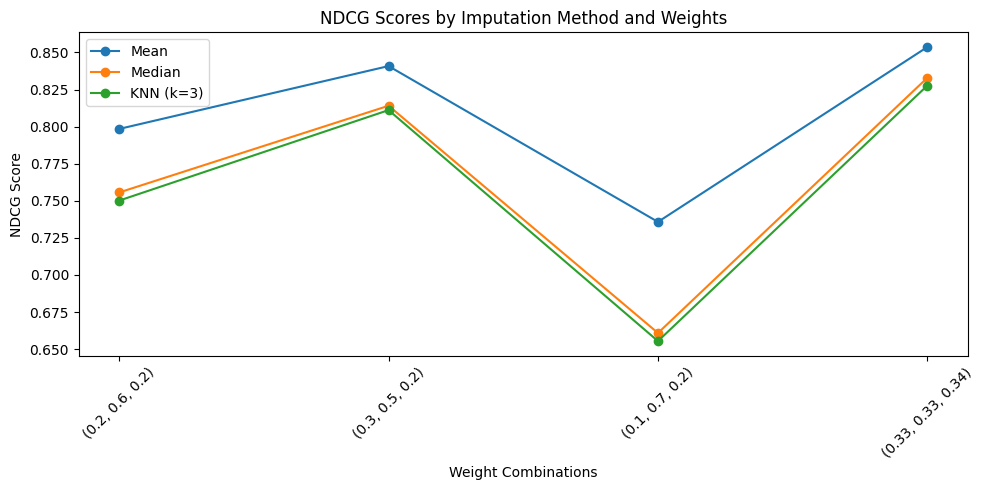

In [41]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt


data = pd.DataFrame(exprience)

# 스케일링 (Min-Max Scaler)
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# 가중치 조합 실험
weight_sets = [(0.2, 0.6, 0.2), (0.3, 0.5, 0.2), (0.1, 0.7, 0.2), (0.33, 0.33, 0.34)]

# 결측치 처리 방법
data.replace("NaN", np.nan, inplace=True)

imputation_methods = {
    "Mean": SimpleImputer(strategy="mean"),
    "Median": SimpleImputer(strategy="median"),
    "KNN (k=3)": KNNImputer(n_neighbors=3),
}

# 결과 저장
results = []

for method_name, imputer in imputation_methods.items():
    # 결측치 처리
    imputed_data = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

    # 스케일링 재적용
    scaled_imputed_data = pd.DataFrame(
        scaler.fit_transform(imputed_data), columns=data.columns
    )

    for weights in weight_sets:
        weighted_scores = (
            weights[0] * scaled_imputed_data["rating"]
            + weights[1] * scaled_imputed_data["like"]
            + weights[2] * scaled_imputed_data["views"]
        )
        # NDCG 계산
        ideal_ranking = np.sort(weighted_scores)[::-1]
        ndcg = ndcg_score([ideal_ranking], [weighted_scores])

        results.append(
            {"Imputation Method": method_name, "Weights": weights, "NDCG": ndcg}
        )

# 결과 정리
results_df = pd.DataFrame(results)
print("\n=== Experiment Results ===")
print(results_df.sort_values(by="NDCG", ascending=False))

# 결과 시각화
plt.figure(figsize=(10, 5))
for method_name in results_df["Imputation Method"].unique():
    subset = results_df[results_df["Imputation Method"] == method_name]
    plt.plot(
        subset["Weights"].astype(str), subset["NDCG"], label=method_name, marker="o"
    )

plt.title("NDCG Scores by Imputation Method and Weights")
plt.xlabel("Weight Combinations")
plt.ylabel("NDCG Score")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# 전처리
import json

with open("../../data/Raw_DB/total.json", "r", encoding="utf-8") as f:
    total = json.load(f)
romance = []
for data in total:
    if (
        data["genre"] == "로맨스"
        and "로판" not in data["keywords"]
        and "판타지" not in data["keywords"]
        and "로맨스판타지" not in data["keywords"]
        and "로맨스 판타지" not in data["keywords"]
    ):
        romance.append(data)
with open("../../data/Raw_DB/romance_only.json", "w", encoding="utf-8") as f:
    json.dump(romance, f, indent=4, ensure_ascii=False)

print(len(romance))

for ro in romance:
    # 조회수, 별점, 관심수 처리
    if ro["rating"] == "-":
        ro["rating"] = 6.2
    if ro["like"] == "-":
        ro["like"] = 95695
    if ro["views"] == "-":
        ro["views"] = 3913761
    ro["score"] = (ro["rating"] * 0.33) + (ro["like"] * 0.34) + (ro["views"] * 0.33)
    del ro["rating"]
    del ro["like"]
    del ro["views"]

    # 가격 처리
    if "쿠키" in ro["price_price"]:
        if ro["price_price"] == "쿠키 34개 쿠키 38개":
            ro["price_price"] = "쿠키 38개"
        ro["price_price"] = ro["price_price"].replace("쿠키 ", "")
        ro["price_price"] = ro["price_price"].replace("개", "")
        ro["price_price"] *= 100
    elif "캐시" in ro["price_price"]:
        ro["price_price"] = ro["price_price"].replace("캐시", "")
    elif ro["price_price"] == "-":
        ro["price_price"] = 0

with open("../../data/romance_only_scaled.json", "w", encoding="utf-8") as f:
    json.dump(romance, f, indent=4, ensure_ascii=False)

46


In [24]:
with open("../../data/romance_only_scaled.json", "r", encoding="utf-8") as f:
    romance = json.load(f)

In [25]:
for ro in romance:
    if "쿠키" in ro["price_price"]:
        if ro["price_price"] == "쿠키 34개 쿠키 38개":
            ro["price_price"] = "쿠키 38개"
        ro["price_price"] = ro["price_price"].replace("쿠키 ", "")
        ro["price_price"] = ro["price_price"].replace("개", "")
        ro["price_price"] *= 100
    elif "캐시" in ro["price_price"]:
        ro["price_price"] = ro["price_price"].replace("캐시", "")
    elif ro["price_price"] == "-":
        ro["price_price"] = 0

In [26]:
romance

[{'id': 65936185,
  'type': '웹소설',
  'platform': '카카오페이지',
  'title': 'X의 사정',
  'status': '완결',
  'thumbnail': 'https://page-images.kakaoentcdn.com/download/resource?kid=YayA1/hAJriURwWS/mHZpd57GkZud7KtKRZrppk&filename=o1/dims/resize/384',
  'genre': '로맨스',
  'description': '온 세상이 너를 버리라 한다. 독종, 술집 작부의 딸, 돈에 미친 꽃뱀. 놓고 싶지 않았다. 아무 곳에도 손 내밀 데 없는 너를. 미치도록 갖고 싶었다. 아무것에도 꺾이지 않는 너를. 차라리 더럽혀서라도. 세상 전부를 등질지라도.  ***  스타트 업 대표 신이제는 대기업과의 M&A를 앞두고 헤어진 여자친구와 재회한다. 수임 의뢰를 받고 찾아온 노무법인 ‘더 온’의 임하라와. 그런데 제 속을 갈기갈기 찢어놓고 사라진 것도 모자라 아무렇지 않은 얼굴로 찾아와 속을 뒤집는 그녀였다. “너무 오래전 일이라 기억도 안 나.”  “지금 잘 살고 있으면 된 거잖아.” 후우, 타는 숨을 뱉어낸 신이제가 거칠게 머리를 넘겼다. 뭘 안다고. 임하라 네가 뭘 안다고 함부로 지껄여. 부서질 대로 부서져 간신히 숨만 쉬고 있는 새끼한테.',
  'keywords': ['현대로맨스',
   '오해물',
   '재회물',
   '첫사랑',
   '계약관계',
   '계략남',
   '직진남',
   '순정남',
   '대형견남',
   '상처남',
   '능력남',
   '절륜남',
   '능력녀',
   '상처녀',
   '친구>연인'],
  'author': '설리연',
  'illustrator': '-',
  'original': '-',
  'age_rating': '15세이용가',
  'url': 'https://page.kakao.com/content/65936185',
  'episo